# Load data

In [1]:
from numpy import loadtxt

features = loadtxt("London_data_2x1000Center_bin100.dat")
position = loadtxt("London_data_2x1000Center_bin100_pos.dat") / 3.5

print features.shape, position.shape

(5400, 344) (5400, 2)



# Split into training and test set

Currently using first 80% as training and last 20% as test set.

In [2]:
nr_samples = features.shape[0]
nr_train = 4000
nr_test = nr_samples - nr_train

train_X = features[:nr_train]
train_Y = position[:nr_train]
test_X = features[nr_train:]
test_Y = position[nr_train:]

print train_X.shape, train_Y.shape, test_X.shape, test_Y.shape

(4000, 344) (4000, 2) (1400, 344) (1400, 2)


## Scale features for SVM

In [3]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
train_X = scaler.fit_transform(train_X.astype('float'))
test_X = scaler.transform(test_X.astype('float'))

print np.min(train_X), np.mean(train_X), np.max(train_X), np.min(test_X), np.mean(test_X), np.max(test_X)

-2.62187344752 -3.36716503355e-16 23.7631112081 -2.62187344752 -0.014371798585 31.3370983738


## Helper function to calculate mean distance

In [4]:
import numpy as np

def mean_distance(estimator, X, y):
    pred_y = estimator.predict(X)
    return np.mean(np.sqrt(np.sum((pred_y - y) ** 2, axis=1)))

def mean_distance_scoring(estimator, X, y):
    return -mean_distance(estimator, X, y)

## Helper class for multiple output regression

In [5]:
import sklearn

class VectorRegression(sklearn.base.BaseEstimator, sklearn.base.RegressorMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        n, m = y.shape
        # Fit a separate regressor for each column of y
        self.estimators_ = [sklearn.base.clone(self.estimator).fit(X, y[:, i])
                               for i in range(m)]
        return self

    def predict(self, X):
        # Join regressors' predictions
        res = [est.predict(X)[:, np.newaxis] for est in self.estimators_]
        return np.hstack(res)

    def set_params(self, **params):
        self.estimator.set_params(**params)
        return self

# Linear Support Vector Regression

In [6]:
from sklearn.svm import SVR
svr = VectorRegression(SVR(kernel="linear"))
svr.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(svr, train_X, train_Y), mean_distance(svr, test_X, test_Y), svr.score(test_X, test_Y))

Train mean distance 13.033269, test mean distance: 21.012235, test R^2 score 0.562594


In [7]:
from sklearn.svm import LinearSVR
svr = VectorRegression(LinearSVR())
svr.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(svr, train_X, train_Y), mean_distance(svr, test_X, test_Y), svr.score(test_X, test_Y))

Train mean distance 13.037369, test mean distance: 21.065713, test R^2 score 0.561714


## Grid search

In [8]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [1, 10, 100, 1000]}]

svr = VectorRegression(LinearSVR())
cv = GridSearchCV(svr, tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.2min finished
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:418: ChangedBehaviorWarning: The long-standing behavior to use the estimator's score function in GridSearchCV.score has changed. The scoring parameter is now used.
  ChangedBehaviorWarning)


{'C': 1} -23.0415490708
Train mean distance 13.036531, test mean distance: 21.087149, test R^2 score -21.087149
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .................................................... C=1 -   2.4s[CV] .................................................... C=1 -   2.4s

[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .................................................... C=1 -   2.5s[CV] .................................................... C=1 -   2.2s

[CV] C=10 ............................................................
[CV] C=1 .............................................................
[CV] ................................................... C=10 -   6.8s[CV] .................................................... C=1 -   3.0s

[CV] C=10 ..........................

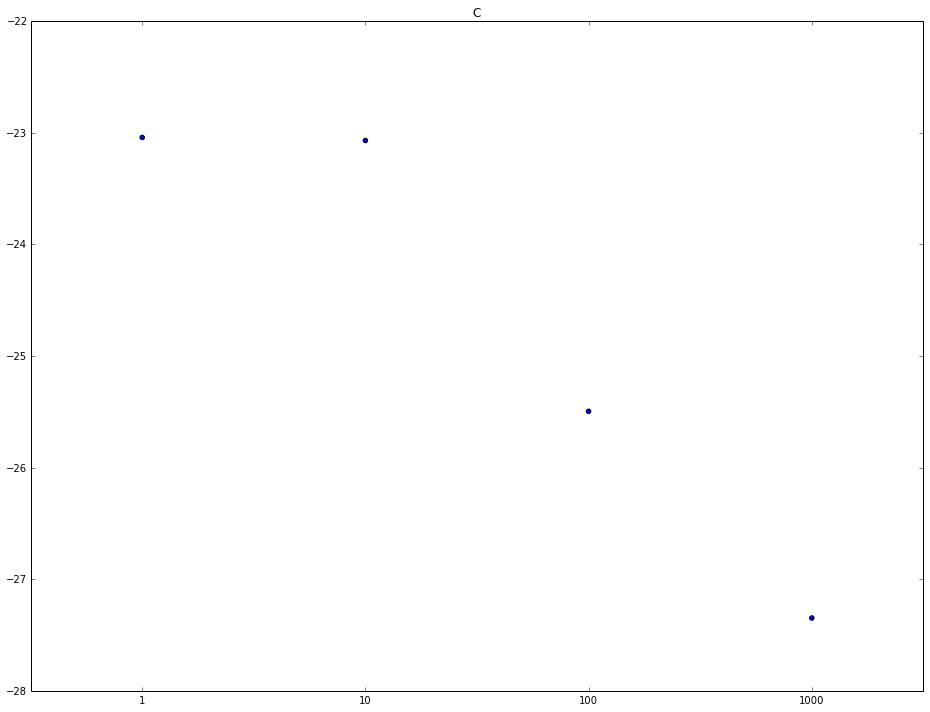

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = int(math.ceil(math.sqrt(len(params))))
    nrows = int(math.ceil(len(params) / ncols))
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

# Polynomial Support Vector Regression

In [10]:
from sklearn.svm import SVR
svr = VectorRegression(SVR(kernel="poly", degree=2))
svr.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(svr, train_X, train_Y), mean_distance(svr, test_X, test_Y), svr.score(test_X, test_Y))

Train mean distance 23.884309, test mean distance: 25.324763, test R^2 score 0.364800


In [11]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [1, 10, 100, 1000],
                     'degree': [1, 3, 5],
                     'gamma': ["auto", 0.1, 0.01, 0.001]}]

svr = VectorRegression(SVR(kernel="poly"))
cv = GridSearchCV(svr, tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 46.1min
[Parallel(n_jobs=2)]: Done 240 out of 240 | elapsed: 424.6min finished


{'C': 1, 'gamma': 0.01, 'degree': 1} -19.951981754
Train mean distance 14.253836, test mean distance: 18.766754, test R^2 score -18.766754[CV] C=1, degree=1, gamma=auto .......................................
[CV] C=1, degree=1, gamma=auto .......................................
[CV] .............................. C=1, degree=1, gamma=auto -  12.3s[CV] .............................. C=1, degree=1, gamma=auto -  12.3s

[CV] C=1, degree=1, gamma=auto .......................................
[CV] C=1, degree=1, gamma=auto .......................................
[CV] .............................. C=1, degree=1, gamma=auto -  11.0s[CV] .............................. C=1, degree=1, gamma=auto -  11.7s

[CV] C=1, degree=1, gamma=auto .......................................
[CV] C=1, degree=1, gamma=0.1 ........................................
[CV] .............................. C=1, degree=1, gamma=auto -   9.9s[CV] ............................... C=1, degree=1, gamma=0.1 -  14.6s

[CV] C=1, 

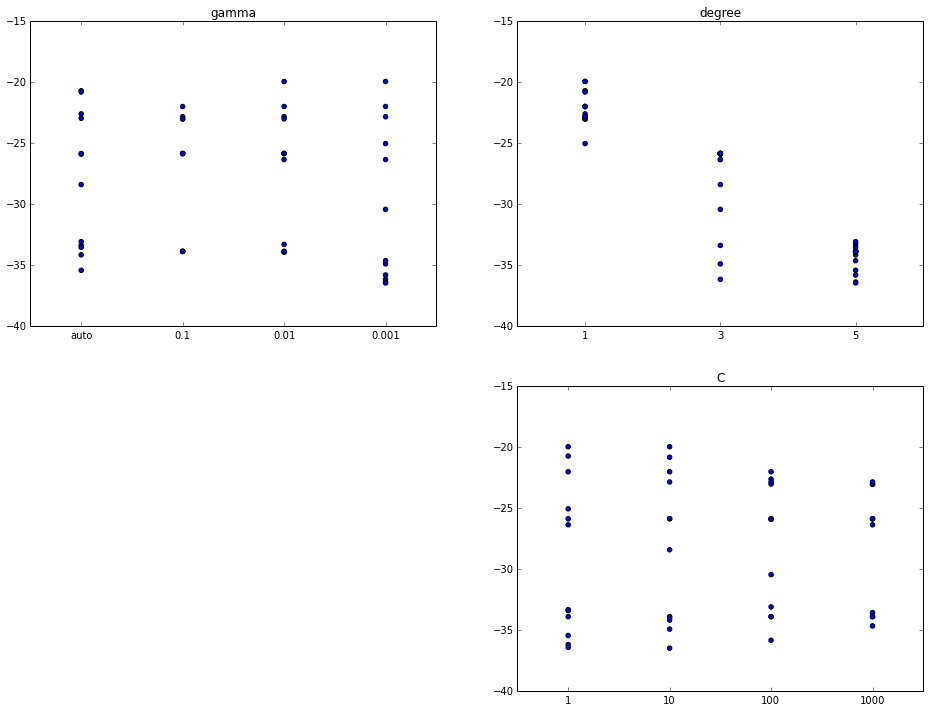

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,12))
    ncols = math.ceil(math.sqrt(len(params)))
    nrows = math.ceil(len(params) / ncols)
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()

# RBF Kernel Support Vector Regression 

In [13]:
from sklearn.svm import SVR
svr = VectorRegression(SVR(kernel="rbf"))
svr.fit(train_X, train_Y)

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(svr, train_X, train_Y), mean_distance(svr, test_X, test_Y), svr.score(test_X, test_Y))

Train mean distance 19.480029, test mean distance: 22.314389, test R^2 score 0.477185


In [14]:
from sklearn.grid_search import GridSearchCV

tuned_parameters = [{'C': [1, 10, 100, 1000],
                     'gamma': ["auto", 0.1, 0.01, 0.001]}]

svr = VectorRegression(SVR(kernel="rbf"))
cv = GridSearchCV(svr, tuned_parameters, scoring=mean_distance_scoring, cv=5, n_jobs=2, verbose=2)
cv.fit(train_X, train_Y)

print cv.best_params_, cv.best_score_

print "Train mean distance %f, test mean distance: %f, test R^2 score %f" % \
    (mean_distance(cv, train_X, train_Y), mean_distance(cv, test_X, test_Y), cv.score(test_X, test_Y))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  6.3min finished


{'C': 1000, 'gamma': 0.001} -17.3382773548
Train mean distance 0.156910, test mean distance: 15.660901, test R^2 score -15.660901[CV] C=1, gamma=auto .................................................
[CV] C=1, gamma=auto .................................................
[CV] ........................................ C=1, gamma=auto -   8.3s[CV] ........................................ C=1, gamma=auto -   8.3s

[CV] C=1, gamma=auto .................................................
[CV] C=1, gamma=auto .................................................
[CV] ........................................ C=1, gamma=auto -   8.1s[CV] ........................................ C=1, gamma=auto -   8.1s

[CV] C=1, gamma=0.1 ..................................................
[CV] C=1, gamma=auto .................................................
[CV] ......................................... C=1, gamma=0.1 -   8.7s[CV] ........................................ C=1, gamma=auto -   8.1s

[CV] C=1, gamma=0.1

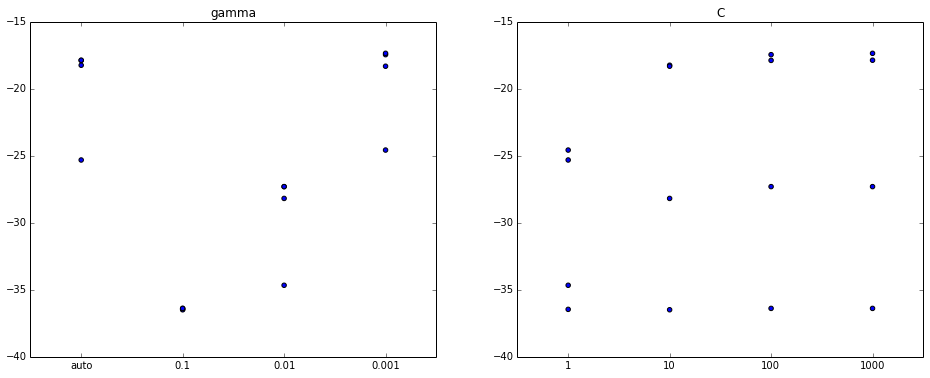

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

for params in tuned_parameters:
    plt.figure(figsize=(16,6))
    ncols = math.ceil(math.sqrt(len(params)))
    nrows = math.ceil(len(params) / ncols)
    for i, (param, values) in enumerate(params.iteritems()):
        #print i, param, values
        value_to_index = {v:i for i,v in enumerate(values)}
        scores = []
        indexes = []
        for cv_tuple in cv.grid_scores_:
            scores.append(cv_tuple.mean_validation_score)
            value = cv_tuple.parameters[param]
            indexes.append(value_to_index[value])
        plt.subplot(nrows,ncols,i)
        plt.scatter(indexes, scores)
        plt.xticks(range(len(values)), values)
        plt.title(param)
    plt.show()